In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240816-155234_continuous.json'
tmodel = load_json_model(model_file)

2024-12-22 19:15:26,630 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240816-155234_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [3]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))
kmodel.repair()

# Compile the jacobian expressions
NCPU = 4
kmodel.prepare()

# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [4]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [5]:
# Select ahe represenatative model
parameter_set_id = '90,8'
parameters = parameter_population[parameter_set_id] 
thermo_index = int(parameter_set_id.split(',')[0])
thermo_sample = tfa_samples.loc[thermo_index]

kmodel.parameters = parameters

In [6]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [7]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [8]:
from skimpy.core.parameters import ParameterValues
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
import numpy as np

# Function for population analysis
def simulate_steady_state_perturbations(parameter, range=[1, 0.5, 2],
                            additional_parameter_changes={},
                            time = [0,5000], # 1uhr to 500min
                            parameter_population=parameter_population, 
                            parameter_population_index=parameter_set_id,
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            ):
    
    # This will be a list of dataframes
    this_results = []

    thermo_index = int(parameter_set_id.split(',')[0])
    thermo_sample = tfa_samples.loc[thermo_index]

    concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                        concentration_scaling=CONCENTRATION_SCALING)

    for k in kmodel.initial_conditions:
            kmodel.initial_conditions[k] = concentrations[k]

    # Load the parameter values 
    kmodel.parameters = parameter_population[parameter_population_index]

    # Integrate additional parameters changes (fold changes)
    for k, v in additional_parameter_changes.items():
        kmodel.parameters[k].value = kmodel.parameters[k].value * v
        print(f'Changing {k} to {kmodel.parameters[k].value}')

    # Perturb the main parameter
    p0 = kmodel.parameters[parameter].value
    
    for perturbation_value in range:
        kmodel.parameters[parameter].value = perturbation_value * p0
        # Dynamic solution            
        sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
        # Get steady state concentrations
        steady_state_concentrations = sol.concentrations.iloc[-1]

        # Compute the fluxes at steady state
        # Get parameters value set 
        parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
        parameter_values = ParameterValues(parameter_values, kmodel)

        steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                        index=kmodel.reactions.keys())
        
        # Add the results to a dataframe 
        steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])
        # Add metadata 
        steady_state_output['perturbation'] = perturbation_value
        steady_state_output['parameter_set'] = parameter_set_id
        steady_state_output['parameter'] = parameter    
        steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]

        this_results.append(steady_state_output)

    # Concatenate the results
    this_results = pd.concat(this_results, axis=1).T

    return this_results


In [9]:
# Sensitivity of fuel uptake to mitochondrial membrane potential 
additional_parameter_changes = {}
results = simulate_steady_state_perturbations('hdca_e', range=np.logspace(-2,2,51, base=2 ), additional_parameter_changes=additional_parameter_changes)

In [10]:
# Sensitivity of fuel uptake to mitochondrial membrane potential 
additional_parameter_changes = {}
for parameter in kmodel.parameters.values(): 
    if 'delta_psi_scaled_MPM_na1_m_na1_c' in str(parameter.symbol):
        additional_parameter_changes[str(parameter.symbol)] = 0 

print(additional_parameter_changes)

{'delta_psi_scaled_MPM_na1_m_na1_c_ASPGLUm': 0, 'delta_psi_scaled_MPM_na1_m_na1_c_ATPS4mi': 0, 'delta_psi_scaled_MPM_na1_m_na1_c_ATPtm': 0, 'delta_psi_scaled_MPM_na1_m_na1_c_CYOOm2i': 0, 'delta_psi_scaled_MPM_na1_m_na1_c_CYOR_u10mi': 0, 'delta_psi_scaled_MPM_na1_m_na1_c_NADH2_u10mi': 0}


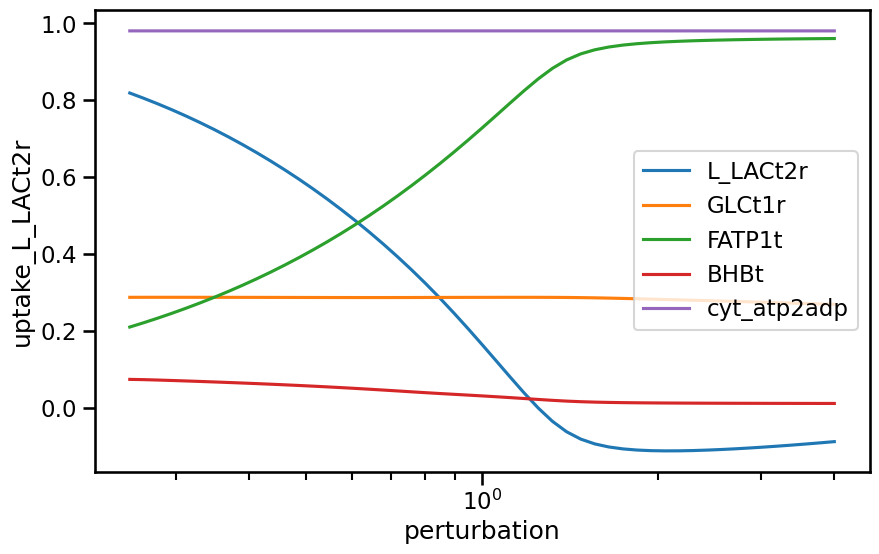

In [11]:
# Plot fuel uptake and energy production
import matplotlib.pyplot as plt
import seaborn as sns

uptake_fluxes = {'L_LACt2r':3,'GLCt1r':6, 'FATP1t':-16, 'BHBt':4,'cyt_atp2adp':1/6.8}

# Compute cabrabon uptake
for uptake in uptake_fluxes:
    results['uptake_'+uptake] = results[uptake] * uptake_fluxes[uptake]
    #results_1['uptake_'+uptake] = results_1[uptake] * uptake_fluxes[uptake]


sns.set_context('talk')
f, ax = plt.subplots(1,1, figsize=(10,6))
color = sns.color_palette('tab10')
for uptake in uptake_fluxes:
    sns.lineplot(data=results, x='perturbation', y='uptake_'+uptake, label=uptake, ax=ax, )
    #sns.lineplot(data=results_1, x='perturbation', y='uptake_'+uptake, label=uptake, ax=ax, linestyle='--')
plt.xscale('log', base=10)




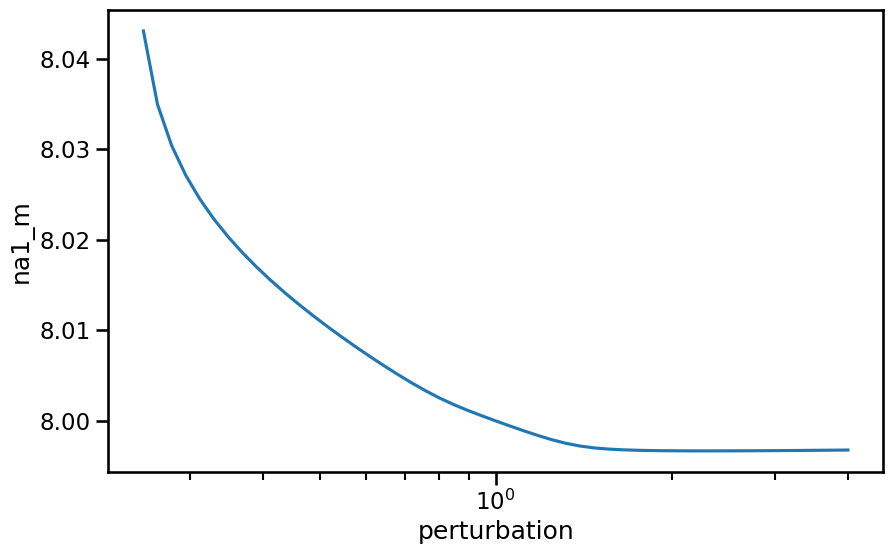

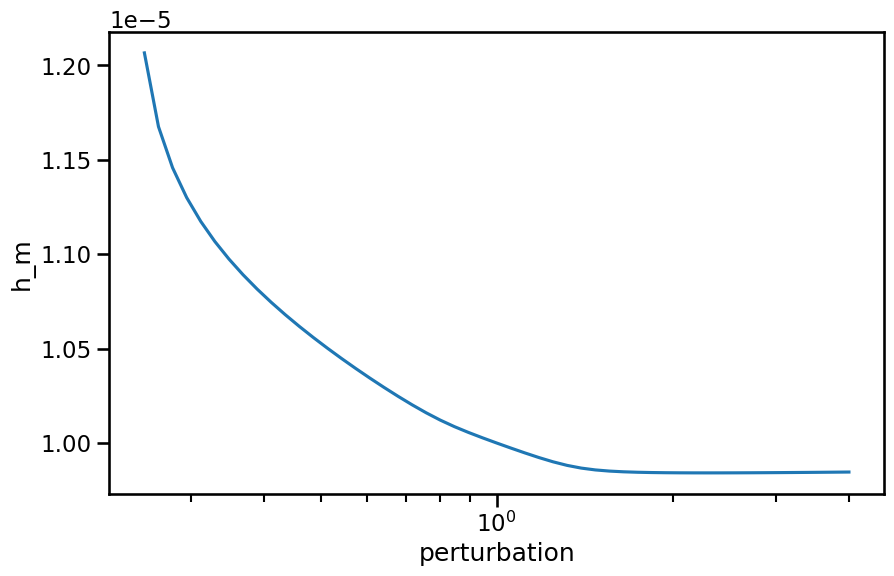

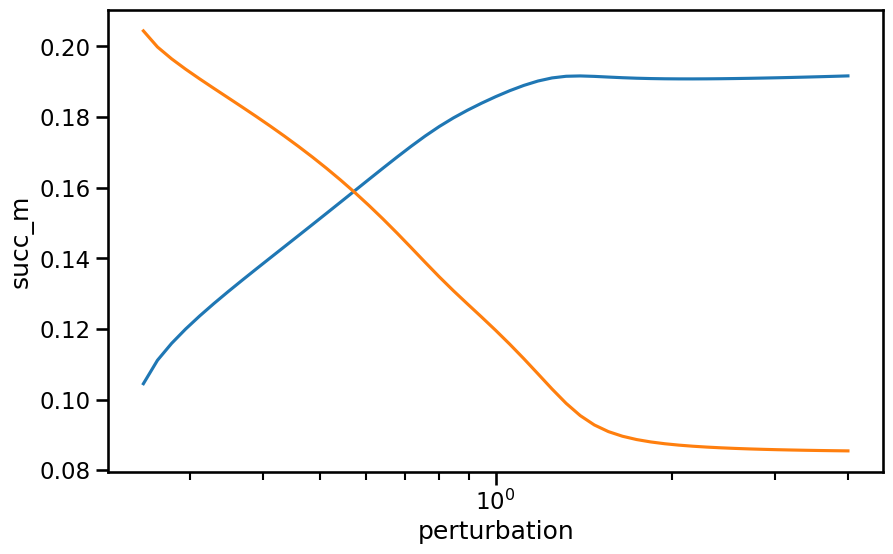

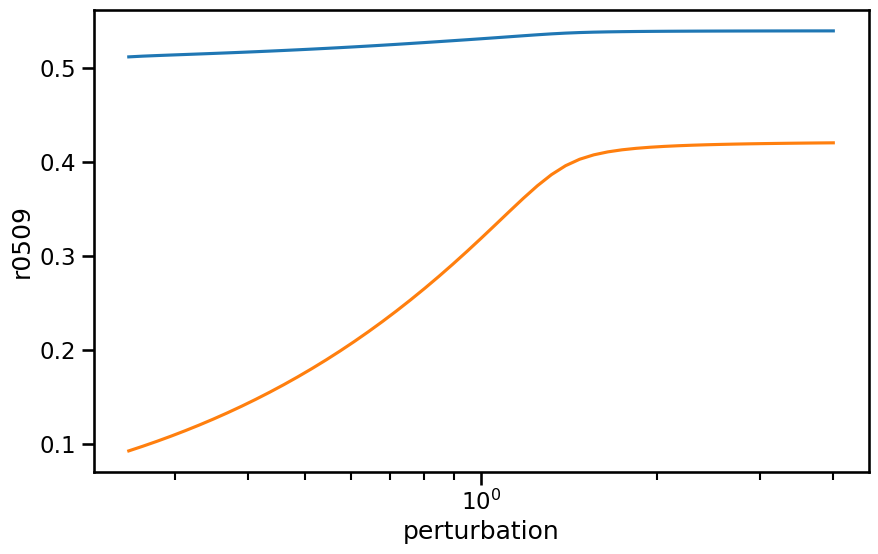

In [12]:
f, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=results, x='perturbation', y='na1_m', ax=ax)
#sns.lineplot(data=results, x='perturbation', y='na1_c', ax=ax)
plt.xscale('log', base=10)

f, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=results, x='perturbation', y='h_m', ax=ax)
#sns.lineplot(data=results, x='perturbation', y='h_c', ax=ax)
plt.xscale('log', base=10)

f, ax = plt.subplots(1,1, figsize=(10,6))   
sns.lineplot(data=results, x='perturbation', y='succ_m', ax=ax)
sns.lineplot(data=results, x='perturbation', y='fum_m', ax=ax)
plt.xscale('log', base=10)

# ETC
f, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=results, x='perturbation', y='r0509', ax=ax)
#sns.lineplot(data=results, x='perturbation', y='NADH2_u10mi', ax=ax)
sns.lineplot(data=results, x='perturbation', y='FADH2ETC', ax=ax)

plt.xscale('log', base=10)